# EikoNet: PiNN for Eikonal Equation

Lu Tian @ SEG

Jingtao Min @ EPM

Project B for SciDL @ ETH 2023

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time
import torch
import torch.optim as optim
import pandas as pd
from drive.MyDrive.DLSC.Common import NeuralNet
from drive.MyDrive.physics_nn import pinn_core
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## PINN

$\begin{aligned} & V\left(\vec{x}_r\right)  =\left[T_0^2\left\|\underset{r}{\nabla} \tau_{s \rightarrow r}\right\|^2+2 \tau_{s \rightarrow r}\left(\vec{x}_r-\vec{x}_s\right) \cdot \underset{r}{\nabla} \tau_{s \rightarrow r}+\tau_{s \rightarrow r}^2\right]^{-\frac{1}{2}}\end{aligned}$, where $T_0=\left\|\vec{x}_r-\vec{x}_s\right\|$.

Loss function: $L=\|V-\hat{V}\|^2$

In [ ]:
class EikonPINN:
    def __init__(self, n_int_, v_mod=lambda x: 4*torch.ones((x.shape[0], 1)), v_bg=4., batch_size=None):
        self.n_int = n_int_
        self.batch_size = batch_size if batch_size is not None else n_int_

        # Extrema of the solution domain (Xs, Ys, Zs, Xr, Yr, Zr) in [0,20]
        self.domain_extrema = torch.tensor([[0, 20], [0, 20], [0, 20],   # Source dimensions
                                            [0, 20], [0, 20], [0, 20]])  # Receiver dimension

        # Velocity model
        self.v_mod = v_mod

        # Background velocity (this is the velocity around which you expect the true model to be)
        self.v_bg = v_bg

        # F Dense NN to approximate the solution of the underlying heat equation
        self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=1,
                                              n_hidden_layers=4,
                                              neurons=20,
                                              regularization_param=0.,
                                              regularization_exp=2.,
                                              retrain_seed=42)
        self.approximate_solution = pinn_core.uniform_MLP(self.domain_extrema.shape[0], 1, 20, 3, activation=torch.nn.Tanh)

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # Training sets S_int as torch dataloader
        self.training_set_int = self.assemble_datasets()


    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    def normalize(self, tens, norm_lim=(-1., 1.)):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return (tens - self.domain_extrema[:, 0])/(self.domain_extrema[:, 1] - self.domain_extrema[:, 0])*(norm_lim[1] - norm_lim[0]) + norm_lim[0]

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        # output_int = torch.zeros((input_int.shape[0], 1))
        output_int = self.v_mod(input_int[:, 3:])
        return input_int, output_int

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_int, output_int = self.add_interior_points()         # S_int
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.batch_size, shuffle=False)

        return training_set_int

    ################################################################################################
    # Customize forward function
    def forward(self, input_int):
        """Forward function
        returns exp(NN(normalize(x))/stdev)/v_bg

        The forward method is so designed that:
            the method can take tensors from the physical domain,
                and the input is scaled to (-1, 1) before entering the neural network;
            the neural network gives an output that is on average between -1 and 1
                and the output is scaled to C*(1/v_bg), where C is around unity but > 0.
        The intuition behind this is that for homogeneous model, the solution is 1/v_bg.
        The scaling factor `stdev` might be up for tuning.
        """
        return torch.exp(self.approximate_solution(self.normalize(input_int))/2.)/self.v_bg

    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int, v_train):
        input_int.requires_grad = True
        tau = self.forward(input_int)

        dist = input_int[:, :3] - input_int[:, 3:]
        T0 = torch.linalg.vector_norm(dist, dim=1)
        grad_tau_r = torch.autograd.grad(tau.sum(), input_int, create_graph=True)[0][:, 3:]

        v_pred = 1/torch.sqrt(T0**2*torch.sum(grad_tau_r**2, dim=1) +
                              2*tau.squeeze()*torch.sum(dist*grad_tau_r, dim=1) +
                              tau.squeeze()**2)
        residual = v_pred - v_train.squeeze()
        return residual.reshape(-1, )

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_int, v_train_int, verbose=True):

        r_int = self.compute_pde_residual(inp_train_int, v_train_int)
        loss_int = torch.mean(r_int**2)

        loss = torch.log10(loss_int)
        if verbose: print("Total loss: ", round(loss.item(), 4), "| Function Loss: ", round(torch.log10(loss_int).item(), 4))

        return loss

    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True, verbose_eval=1):
        n_eval = 0
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("============================= ", epoch, " ================================")

            for j, (inp_train_int, v_train_int) in enumerate(self.training_set_int):

                def closure():
                    nonlocal n_eval
                    n_eval += 1
                    loss_verbose = True if (n_eval%verbose_eval == 0) else False
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_int, v_train_int, verbose=loss_verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history


## PINN Setup

<!-- Weighted Sampling $w=\frac{|\hat{V}-V|}{V}$ with $[min, max] = [0.1, 0.9]$ -->

Set up the instance.

In [ ]:
def linear_init_xavier(m):
    """Use Xavier uniform initialization on linear layers.
    """
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=torch.nn.init.calculate_gain("tanh"))
        m.bias.data.fill_(0)

n_int = 10000

eikon_pinn = EikonPINN(n_int, batch_size=1000)
eikon_pinn.approximate_solution.apply(linear_init_xavier)

Sequential(
  (0): Linear(in_features=6, out_features=20, bias=True)
  (1): Tanh()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Tanh()
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Tanh()
  (6): Linear(in_features=20, out_features=20, bias=True)
  (7): Tanh()
  (8): Linear(in_features=20, out_features=1, bias=True)
)

Sampling points

**Do not run this code block UNLESS the sample number is less than 1000!**

**Can be somewhat slow!**

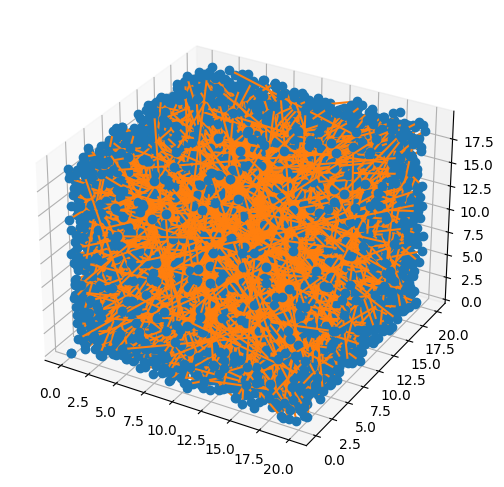

In [ ]:
fig = plt.figure(figsize=(6, 8))
ax = fig.add_subplot(projection="3d")

for input_train, v_train in eikon_pinn.training_set_int:
    # print(input_train.shape, output_train.shape)
    for sr_pair in input_train:
        sr_pair_plot = sr_pair.detach().cpu().numpy().reshape(2, 3)
        ax.plot(sr_pair_plot[:, 0], sr_pair_plot[:, 1], sr_pair_plot[:, 2], 'o-', color="tab:orange", markerfacecolor='tab:blue', markeredgecolor="tab:blue")

plt.show()

Distribution of the output samples

Used for determining the normalizations.

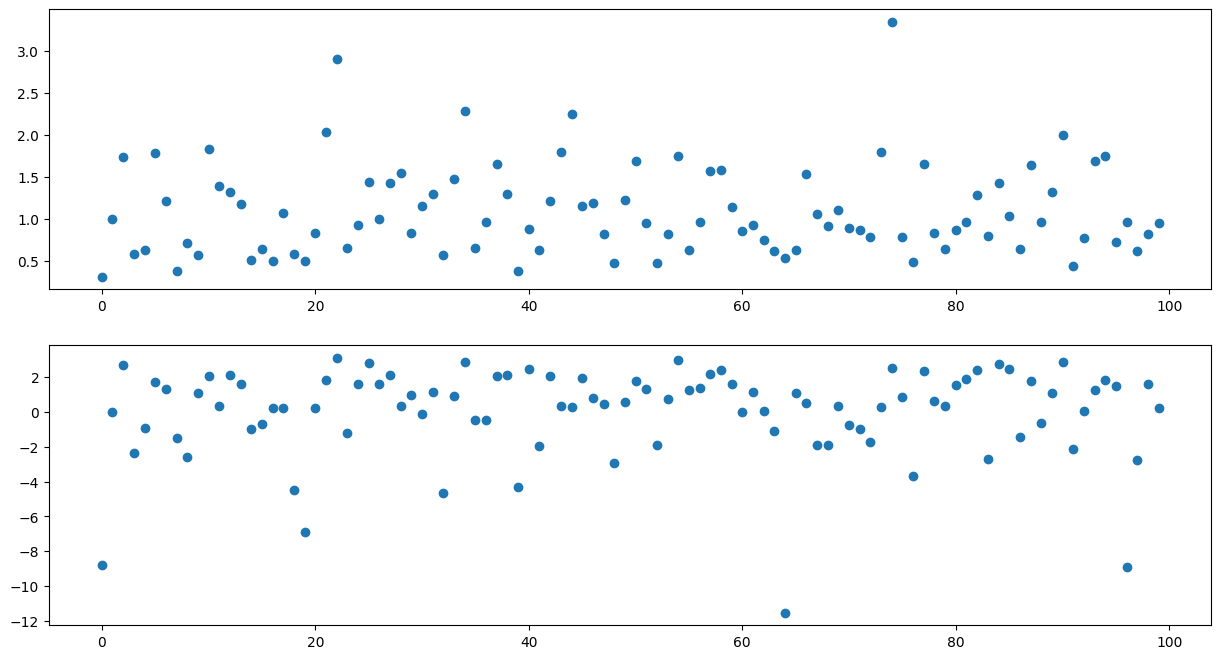

In [ ]:
tau = eikon_pinn.forward(input_train)*eikon_pinn.v_bg
res = eikon_pinn.compute_pde_residual(input_train, v_train)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))

ax = axes[0]
ax.scatter(np.arange(tau.shape[0]), tau.detach().cpu().numpy())

ax = axes[1]
ax.scatter(np.arange(res.shape[0]), res.detach().cpu().numpy())

plt.show()

## Velocity Model
1. Homogeneous model
2. One from the paper to compare?
3. Model includes a fault plane

In [ ]:
### Velocity models
class Vel_Model_Homo:
    def __init__(self):
        self.velocity = 5.5

    def eval(self,X):
        Y = np.ones((X.shape[0],3))*self.velocity
        return Y

    def __call__(self, X):
        return self.eval(X)

class Vel_Model_Fault:
    def __init__(self):
        # Velocity values
        self.velocity_outside = 5.5
        self.velocity_inside  = 4.

        # Fault
        self.thick = 4
        self.dip = 60

    def eval(self,X):
        Y = np.ones((X.shape[0], 2)) * self.velocity_outside

        # Define the fault plane
        dip_rad = np.radians(self.dip)
        x_fault = X[:, 0]
        y_fault = X[:, 1] * np.cos(dip_rad)

        # Determine the points inside the fault
        ins = (y_fault <= self.thick / np.sin(dip_rad))

        # Assign velocities inside the fault
        Y[ins] = self.velocity_inside

        return Y

## Training

Training setup

In [ ]:
optimizer_LBFGS = optim.LBFGS(eikon_pinn.approximate_solution.parameters(),
                              lr=0.5,
                              max_iter=1000,
                              max_eval=1500,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)

optimizer_ADAM = optim.Adam(eikon_pinn.approximate_solution.parameters(),
                            lr=0.001, weight_decay=1e-5)

Training the network

In [ ]:
loss_log = eikon_pinn.fit(num_epochs=1000, optimizer=optimizer_ADAM, verbose=True, verbose_eval=100)

=============================  0  ================================
=============================  1  ================================
=============================  2  ================================
=============================  3  ================================
=============================  4  ================================
=============================  5  ================================
=============================  6  ================================
=============================  7  ================================
=============================  8  ================================
=============================  9  ================================
Total loss:  0.1705 | Function Loss:  0.1705
=============================  10  ================================
=============================  11  ================================
=============================  12  ================================
=============================  13  ================================
=============

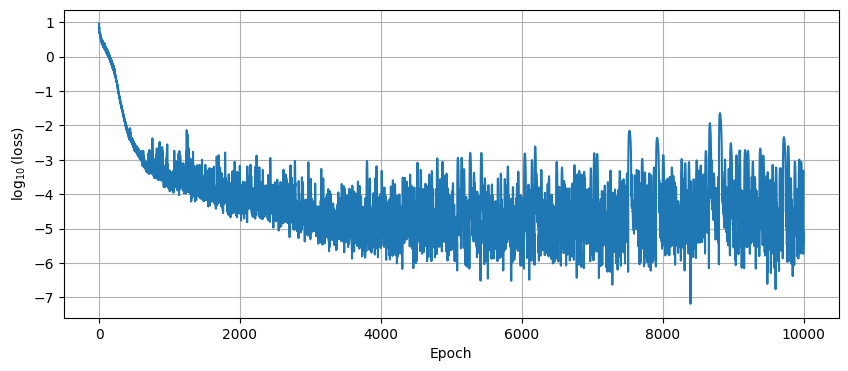

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(loss_log)
ax.grid()
ax.set_xlabel("Epoch")
ax.set_ylabel("$\log_{10}$(loss)")

plt.show()

## Validation

In [ ]:
src_loc = np.array([10., 10., 1.])
x_grid, y_grid, z_grid = np.meshgrid(np.linspace(0., 20., 101), np.linspace(0., 20., 101), np.linspace(0., 20., 101), indexing='ij')
pt_validate = np.stack([x_grid.flatten(), y_grid.flatten(), z_grid.flatten()], axis=-1)
pt_validate = np.c_[np.array([src_loc]*pt_validate.shape[0]), pt_validate]

tau_validate = eikon_pinn.forward(torch.from_numpy(pt_validate).to(torch.float32))
tau_validate = tau_validate.detach().cpu().numpy().reshape(*x_grid.shape)
# traveltime = tau_validate*np.linalg.norm(pt_validate[:, 3:] - pt_validate[:, :3], axis=-1)
# traveltime = traveltime.reshape(*x_grid.shape)
v_validate = eikon_pinn.compute_pde_residual(torch.from_numpy(pt_validate).to(torch.float32), torch.tensor(0.))
v_validate = v_validate.detach().cpu().numpy().reshape(*x_grid.shape)

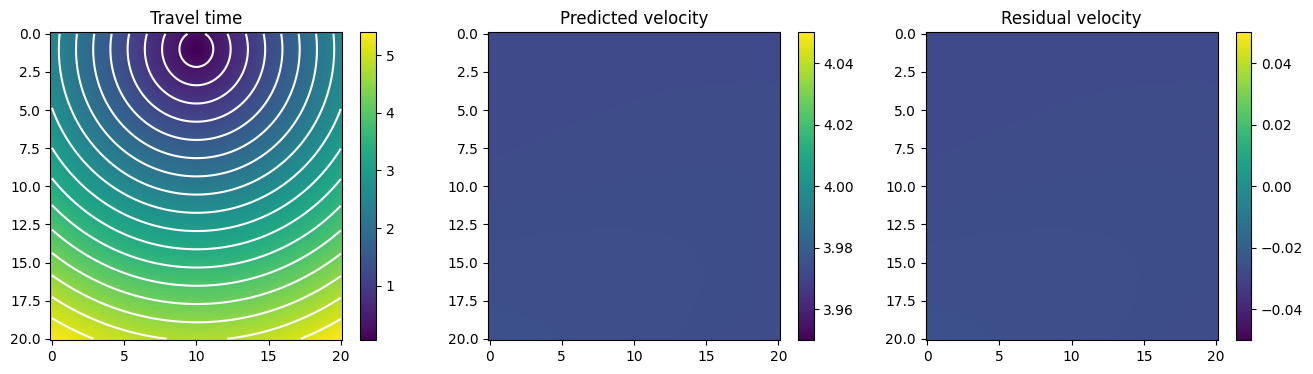

In [ ]:
id_y = 51
traveltime = np.linalg.norm(pt_validate[:, 3:] - pt_validate[:, :3], axis=-1).reshape(*x_grid.shape)
traveltime *= tau_validate

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

ax = axes[0]
# im = ax.pcolormesh(x_grid[:, id_y, :].T, z_grid[:, id_y, :].T, tau_validate[:, id_y, :])
im = ax.pcolormesh(x_grid[:, id_y, :], z_grid[:, id_y, :], traveltime[:, id_y, :])
ax.contour(x_grid[:, id_y, :], z_grid[:, id_y, :], traveltime[:, id_y, :], 18, colors="white")
ax.invert_yaxis()
ax.set_title("Travel time")
plt.colorbar(im, ax=ax)

ax = axes[1]
im = ax.pcolormesh(x_grid[:, id_y, :], z_grid[:, id_y, :], v_validate[:, id_y, :], clim=(3.95, 4.05))
ax.invert_yaxis()
ax.set_title("Predicted velocity")
plt.colorbar(im, ax=ax)

ax = axes[2]
im = ax.pcolormesh(x_grid[:, id_y, :], z_grid[:, id_y, :], (v_validate[:, id_y, :] - 4), clim=(-0.05, 0.05))
ax.invert_yaxis()
ax.set_title("Residual velocity")
plt.colorbar(im, ax=ax)

plt.show()

The code block below will wipe the weights and bias in the network to zero.

This would give the ground truth solution for homogeneous model, under the current normalization and scaling scheme implemented in `EikoPINN.forward`.

In [ ]:
def wipe_zero(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.zeros_(m.weight)
        m.bias.data.fill_(0)

eikon_pinn.approximate_solution.apply(wipe_zero)

Sequential(
  (0): Linear(in_features=6, out_features=20, bias=True)
  (1): Tanh()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Tanh()
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Tanh()
  (6): Linear(in_features=20, out_features=20, bias=True)
  (7): Tanh()
  (8): Linear(in_features=20, out_features=1, bias=True)
)